In [1]:
!pip install pandas scikit-learn

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [13]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Bj8TrWqSUBWlBQX-WSoRj40xJFWht5Uac6rX4_mCv12G',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.eu-gb.cloud-object-storage.appdomain.cloud')

bucket = 'nsapprediction-donotdelete-pr-vru6acg1g8ih3f'
object_key = 'sample.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_2 = pd.read_csv(body)
df_2.head(10)


,fin_year,mnth,lgd_state_code,state_name,lgd_district_code,district_name,scheme_code,total_beneficiaries,total_sc,total_st,total_gen,total_obc,total_aadhar,total_mobileno,lastUpdated
0,2024-2025,6,1,JAMMU AND KASHMIR,1,ANANTNAG,IGNDPS,104,0,2,101,1,104,19,2024-07-29
1,2024-2025,6,1,JAMMU AND KASHMIR,11,PULWAMA,IGNDPS,100,0,6,86,8,99,57,2024-07-29
2,2024-2025,6,1,JAMMU AND KASHMIR,620,KISHTWAR,IGNDPS,107,0,0,107,0,104,31,2024-07-29
3,2024-2025,6,10,BIHAR,190,BANKA,IGNDPS,1990,213,61,1500,216,1402,1471,2024-07-29
4,2024-2025,6,10,BIHAR,196,GAYA,IGNDPS,1665,407,31,1142,85,1191,1221,2024-07-29
5,2024-2025,6,10,BIHAR,199,JEHANABAD,IGNDPS,378,62,15,223,78,239,225,2024-07-29
6,2024-2025,6,10,BIHAR,200,KAIMUR (BHABUA),IGNDPS,1624,349,65,965,245,1021,1339,2024-07-29
7,2024-2025,6,10,BIHAR,201,KATIHAR,IGNDPS,2102,111,22,1817,152,1429,1629,2024-07-29
8,2024-2025,6,10,BIHAR,202,KHAGARIA,IGNDPS,1846,165,27,1453,201,1221,1495,2024-07-29
9,2024-2025,6,10,BIHAR,204,LAKHISARAI,IGNDPS,2371,327,28,1511,505,1487,1743,2024-07-29


In [17]:
df_2.columns

Index(['fin_year', 'mnth', 'lgd_state_code', 'state_name', 'lgd_district_code',
       'district_name', 'scheme_code', 'total_beneficiaries', 'total_sc',
       'total_st', 'total_gen', 'total_obc', 'total_aadhar', 'total_mobileno',
       'lastUpdated'],
      dtype='object')

In [19]:
df_2.columns = df_2.columns.str.strip()


In [21]:
df_2 = df_2.dropna()

X = df_2.drop(columns=[
    'fin_year', 'mnth', 'lgd_state_code', 'state_name', 'lgd_district_code',
       'district_name', 'scheme_code', 'total_beneficiaries', 'total_sc',
       'total_st', 'total_gen', 'total_obc', 'total_aadhar', 'total_mobileno',
       'lastUpdated'
])
y = df_2['total_beneficiaries']


In [23]:
df_2 = df_2.dropna()

X = df_2[['total_sc', 'total_st', 'total_gen', 'total_obc', 'total_aadhar', 'total_mobileno']]
y = df_2['total_beneficiaries']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Predict on sample
print("Sample prediction:", model.predict(X_test.iloc[0:1])[0])


MAE: 3.748140596469872
R² Score: 0.9998847128395911
Sample prediction: 876.09


In [24]:
import joblib
joblib.dump(model, 'nsap_model.pkl')

['nsap_model.pkl']

In [25]:
df_results = X_test.copy()
df_results['Actual_Beneficiaries'] = y_test.values
df_results['Predicted_Beneficiaries'] = y_pred

df_results.to_csv('nsap_predictions.csv', index=False)


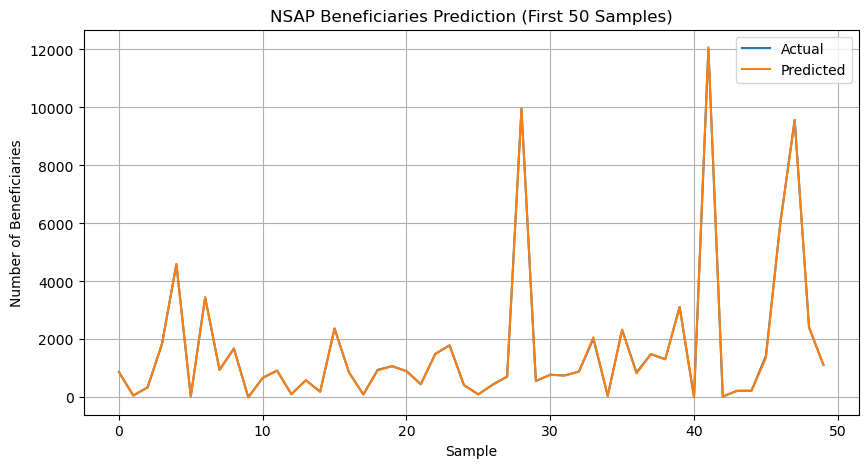

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:50], label='Actual')
plt.plot(y_pred[:50], label='Predicted')
plt.title("NSAP Beneficiaries Prediction (First 50 Samples)")
plt.xlabel("Sample")
plt.ylabel("Number of Beneficiaries")
plt.legend()
plt.grid(True)
plt.show()


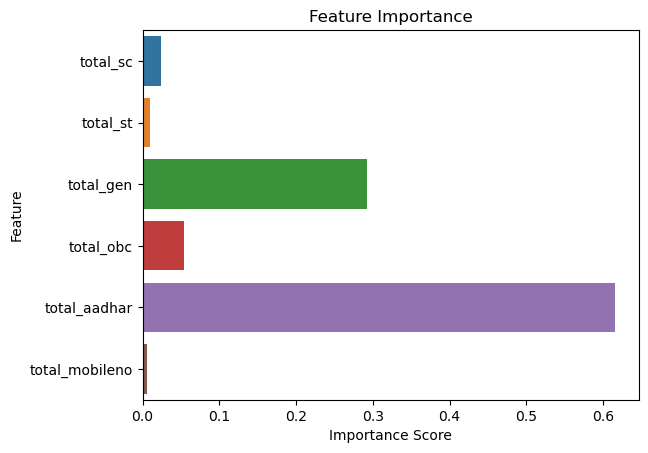

In [27]:
import seaborn as sns

feature_importance = pd.Series(model.feature_importances_, index=X.columns)
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [28]:
loaded_model = joblib.load('nsap_model.pkl')
new_prediction = loaded_model.predict(X_test.iloc[1:2])
print("Loaded model prediction:", new_prediction[0])


Loaded model prediction: 63.0
